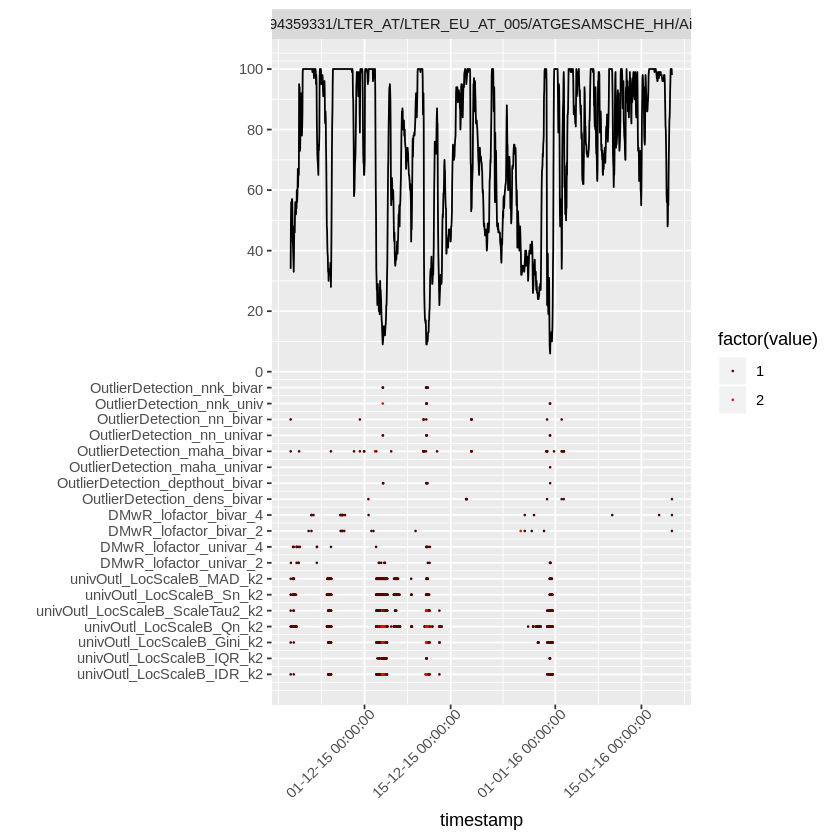

In [11]:

library(ggplot2)
library(reshape2)
library(httr)

request_url_block_sos="https://90.147.102.53:8080/v1/qs_blocking"

query_block_sos_lter=list(
  sosendpoint="https://lter-at-sos.sos.cdn.lter-europe.net/service",
  offering="/1568294359331/LTER_AT/LTER_EU_AT_005/ATGESAMSCHE_HH/Air/1/raw",
  begin="2015-11-19T00:00:00.000Z",
  end="2016-01-19T23:59:59.000Z",
  offeringonly="true",
  usecache=TRUE,
  windowwidth=40,
  windowinterval=14
)

request_url=request_url_block_sos
query=query_block_sos_lter


set_config( config( ssl_verifypeer = 0L, ssl_verifyhost = 0L ) )
res=GET(request_url, query=query)

zipfile=tempfile(fileext=".zip")
fle=file(zipfile, "wb")
writeBin(content(res), fle)
close(fle)

results=utils::unzip(zipfile, list=TRUE)

files=results$Name[grepl("total_timeseries_plusoutlier.dat", results$Name)]

ts=read.table(unz(zipfile,files), sep = ";", header=T)

ts=ts[ts$FIELDNAME!="",]
ts$FIELDNAME=factor(ts$FIELDNAME)

ts$timestamp=as.POSIXct(gsub("(\\(|\\))","", as.character(ts$timestamp)), format = "%d-%m-%y %H:%M:%S", tz="UTC")


ts=ts[order(ts$timestamp),]

ts_outliers=melt(ts[,-c(3,4,5,6,7,8,9,10)], id.vars=c("timestamp", "FIELDNAME"))

ts_outliers=ts_outliers[!is.na(ts_outliers$value) & ts_outliers$value > 0,]

ts_outliers$variable=factor(ts_outliers$variable)

minval=min(ts$VALUE, na.rm=T)
maxval=max(ts$VALUE, na.rm=T)

diff=maxval-minval
diffLog10=round(log10(diff))
rounder=(10^(diffLog10-1))
interval=round((diff/5)/rounder)*rounder

minLab=floor(minval/interval)*interval
maxLab=ceiling(maxval/interval)*interval

fact=maxLab/length(levels(ts_outliers$variable))
y_breaks=c(unique(as.numeric(ts_outliers$variable)-(1+length(levels(ts_outliers$variable))))*fact, seq(minLab, maxLab, interval)) 
y_labels=c((levels(ts_outliers$variable)), seq(minLab, maxLab, interval))

ggplot(ts, aes(x=timestamp)) + 
  facet_grid(.~FIELDNAME) +
  geom_line(aes(y=VALUE, group=FIELDNAME)) + 
  geom_point(data=ts_outliers, na.rm=TRUE, aes(y=(as.numeric(variable)-(1+length(levels(variable))))*fact,  color=factor(value)), size=0.1) +
  scale_color_manual(values=c("#550000", "#FF0000")) +
  scale_y_continuous("", breaks=y_breaks, labels=y_labels) +
  scale_x_datetime(date_labels="%d-%m-%y %H:%M:%S") + 
  theme(axis.text.x=element_text(angle = 45, hjust=0.95))
  

